## 1. Setup Notebook Environment

### 1.1 Import all required packages.

In [55]:
import ssl
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import EuroSAT
from avalanche.benchmarks.utils import as_avalanche_dataset
from avalanche.benchmarks.datasets.dataset_utils import default_dataset_location 
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics, \
    loss_metrics, timing_metrics, cpu_usage_metrics, confusion_matrix_metrics, disk_usage_metrics
from avalanche.models import SimpleMLP
from avalanche.logging import InteractiveLogger, TextLogger, TensorboardLogger
from avalanche.training.plugins import EvaluationPlugin
from avalanche.training.supervised import Naive

### 1.2 Configure settings for the optimizer and scheduler.

In [56]:
config = {'train_test_split':0.1, # train test split ratio
            'tr_val_split':0.2, # train validation split ratio
            'seed':42, # random seed
            'mini_batch_size':128,
            'epochs':20,
            
            # Settings for the optimizer AdamW
            'lr':1e-3, # learning rate
            'weight_decay':5e-4,

            # Settings for the lr_scheduler CosineAnnealingWarmRestarts
            't_0':5, # Number of iterations for the first restart.
            'eta_min':1e-5, # Minimum learning rate
          }

### 1.3 Define a function to set a random seed for reproducibility assurance:
* Manage sources of randomness that may lead to varying behaviors in multiple executions of your application.

In [57]:
def set_random_seed(seed=42):
    random.seed(seed) # set python seed
    np.random.seed(seed) # seed the global NumPy random number generator(RNG)
    torch.manual_seed(seed) # seed the RNG for all devices(both CPU and CUDA) 

set_random_seed(seed=config['seed'])

### 1.4 Tracks the active GPU and allocates all new CUDA tensors on that device by default.

In [58]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

## 2. Data Preparation:

### 2.1 Preparing the dataset:

In [59]:
datadir = default_dataset_location('eurosat')
# Transform pipeline
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

# Dataset download
ssl._create_default_https_context = ssl._create_unverified_context # Turn off the ssl verification.
dataset = EuroSAT(root=datadir,transform=transform, download=True)

# Train/Test split
n = int(len(dataset) * (1 - config['train_test_split']))
eurosat_train, eurosat_test = torch.utils.data.random_split(dataset, [n, len(dataset) - n])

eurosat_train = as_avalanche_dataset(eurosat_train)
eurosat_test = as_avalanche_dataset(eurosat_test)

### 2.2 Visualize Training Data

Image 24270 's label : 8 River


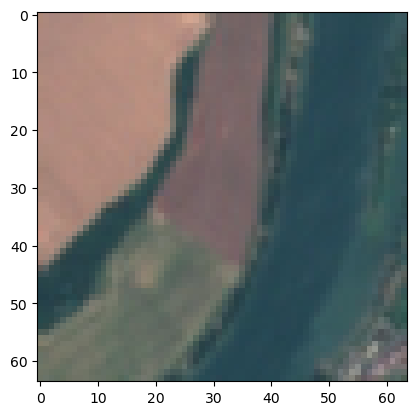

In [71]:
# Randomly select an image from the Training Data for visualization and print its corresponding label.
classes = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
random_index = random.randrange(len(eurosat_train)) # random select an index
random_image = eurosat_train[random_index][0].numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
random_image = std * random_image + mean
random_image = np.clip(random_image, 0, 1)
print("Image", random_index, "'s label :", eurosat_train[random_index][1], classes[eurosat_train[random_index][1]])
plt.imshow(random_image)

In [ ]:
# MODEL CREATION
model = SimpleMLP(num_classes=scenario.n_classes)

# DEFINE THE EVALUATION PLUGIN and LOGGERS
# The evaluation plugin manages the metrics computation.
# It takes as argument a list of metrics, collectes their results and returns
# them to the strategy it is attached to.

# log to Tensorboard
tb_logger = TensorboardLogger()

# log to text file
text_logger = TextLogger(open('log.txt', 'a'))

# print to stdout
interactive_logger = InteractiveLogger()

eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    timing_metrics(epoch=True, epoch_running=True),
    forgetting_metrics(experience=True, stream=True),
    cpu_usage_metrics(experience=True),
    confusion_matrix_metrics(num_classes=scenario.n_classes, save_image=False,
                             stream=True),
    disk_usage_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loggers=[interactive_logger, text_logger, tb_logger]
)

# CREATE THE STRATEGY INSTANCE (NAIVE)
cl_strategy = Naive(
    model, SGD(model.parameters(), lr=0.001, momentum=0.9),
    CrossEntropyLoss(), train_mb_size=500, train_epochs=1, eval_mb_size=100,
    evaluator=eval_plugin)

# TRAINING LOOP
print('Starting experiment...')
results = []
for experience in scenario.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    # train returns a dictionary which contains all the metric values
    res = cl_strategy.train(experience)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # test also returns a dictionary which contains all the metric values
    results.append(cl_strategy.eval(scenario.test_stream))